In [1]:
import itertools
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import ternary

# Functions

In [2]:
def clean_data(raw, z_threshold=2.5, min_listen_time=20):
    """
    Drops entries with abnormal listening_time (z-score too high or time too low).
    Also removes entries with unknown origin
    :param min_listen_time: entries where the user has listened for less than this (s) are dropped
    :param z_threshold: maximum z-score allowed in the dataset
    :param raw: raw data to be processed
    :return: clean dataset (pd.DataFrame)
    """
    if z_threshold > 0:
        print("Computing z-score...")
        z = np.abs(stats.zscore(raw["listening_time"]))

    print("Cleaning...")
    # Entries with a z-score above the threshold will be dropped (also instant-skips of listening_time < X)
    if z_threshold > 0:
        raw.drop(raw[z > z_threshold].index, inplace=True)
    raw.drop(raw[raw.listening_time < min_listen_time].index, inplace=True)
    return raw[(raw["origin"] != "unknown")]

In [3]:
# Keep this stuff updated if needed
TYPE_DICT = {"flow": "algo", "reco_algo": "algo", "playlist_edito": "edit", "reco_social": "edit", 
             "charts": "edit", "radio": "edit", "podcast": "edit", "page_playlist": "orga", 
             "page_album": "orga", "page_artist": "orga", "user_library": "orga", "search": "orga", 
             "api": "orga", "page_track": "orga"}
def is_reco(origin):
    return TYPE_DICT[origin]

In [4]:
def bin_artists(artist_data, bin_amnt=25):
    """
    takes in raw data from streams (with added art_id -- see "formatting/add_artists.py") and bins artists together
    according to their "mainstream" status -- i.e. how much they are listened to.
    :param bin_amnt: amount of bins the artists will be put into AT MOST
    :param separate_reco: Whether or not to add a "recommended" column to the DF
    :param artist_data: DataFrame ["user_id", "ts", "sng_id", "album_id", "listening_time", "listen_type", "origin", "art_id"]
    :return: the same DataFrame with added columns [..., "bin_nb", "recommended"] -- unless recommended is not wanted
    """
    print("Counting artist occurences...")
    artist_count = artist_data["art_id"].value_counts(normalize=False).sort_values(ascending=True).to_frame() \
        .reset_index().rename(columns={"index": "art_id", "art_id": "plays"})
    artist_count["cumplays"] = artist_count["plays"].cumsum()

    print("Binning artists...")
    # Cutting into bin_amnt bins (duplicate bins allowed -- and necessary for small datasets and large amount of bins)
    artist_count["bin"] = pd.cut(artist_count["cumplays"], bin_amnt, duplicates="drop")
    print(f"Number of artists per bin: \n{artist_count.groupby('bin').size()}")

    # Assigning corresponding numbers to bins
    artist_count["bin_nb"] = (artist_count["bin"].cat.codes + 1).values
    print(f"Artists binned into {artist_count['bin_nb'].max()} categories.")

    artist_data = artist_data.merge(artist_count[["art_id", "bin_nb"]], left_on="art_id", right_on="art_id")

    return artist_data

In [5]:
def get_user_frame(bin_distribution):
    # Vectorized computing of the users' bin ratios
    user_frame = main_dist.to_frame()
    user_frame.columns = ["ratio"]

    # Our user_frame ends up with [user, bin_nb, ratio]
    user_plays = user_frame["ratio"].sum(level=0)
    user_frame = user_frame.unstack('bin_nb').divide(bin_distrib, level=1).divide(user_plays, axis=0).stack("bin_nb")

    user_frame = user_frame.reset_index()
    
    return user_frame

In [6]:
# FILE_NAME = "../../data/artist_streams.csv"
FILE_NAME = "../../data/spring2020/all_simple.csv"
SAVE_NAME = "../../data/mainstream_data.csv"
MIN_OBS = 100
SEPARATE_RECO = False
BIN_AMNT = 4

sns.set_palette(sns.color_palette("colorblind"))
sns.set_style("darkgrid")

In [7]:
print("Reading data...")
data = pd.read_csv(FILE_NAME)#.head(100000)
# data = clean_data(data, z_threshold=3)
print(f"Data shape: {data.shape[0]} lines, {data.shape[1]} columns")

print(f"Removing users with fewer than {MIN_OBS} observations...")
remove_idx = data.groupby(["user_id"]).size()
remove_idx = remove_idx[remove_idx < MIN_OBS].index.unique()

data = data[~data.user_id.isin(remove_idx)]
print(f"Removed {len(remove_idx)} users.")
data

Reading data...
Data shape: 48918125 lines, 4 columns
Removing users with fewer than 100 observations...
Removed 251 users.


,user_id,sng_id,origin,artist_id
0,49d2e98bcb58048af766d54872159ebb9849973f,675801,page_artist,611
1,948e06ab49e2af86f67afd19778060049d770a13,6626876,page_artist,611
2,753b6c11ec65e8fb293e9f080a2494eb10f82f81,4288159,page_artist,611
3,948e06ab49e2af86f67afd19778060049d770a13,368596071,page_artist,611
4,a643a25dfac987b543948c02e9de9872414e2fa4,352060551,page_artist,891
...,...,...,...,...
48918120,2707be884a98f7daf233ef9e814f4a7a72cc5d6f,124603268,page_playlist,246791
48918121,2707be884a98f7daf233ef9e814f4a7a72cc5d6f,467988092,page_playlist,4907510
48918122,2707be884a98f7daf233ef9e814f4a7a72cc5d6f,654827842,page_playlist,4907510
48918123,2707be884a98f7daf233ef9e814f4a7a72cc5d6f,356902671,page_playlist,616943


In [8]:
# Woops
data = data.rename(columns={"artist_id": "art_id"})

In [9]:
# Bin artists together
data = bin_artists(data, BIN_AMNT)

print(f"Standard deviation of amount of plays per bin: {np.std(data.groupby(['bin_nb']).size().values)}")

Counting artist occurences...
Binning artists...
Number of artists per bin: 
bin
(-48902.88, 12225971.0]     163130
(12225971.0, 24451941.0]      1441
(24451941.0, 36677911.0]       312
(36677911.0, 48903881.0]        72
dtype: int64
Artists binned into 4 categories.
Standard deviation of amount of plays per bin: 40577.4458004382


In [10]:
# Reversing bin numbers -- just a dirty little workaround to have the "mainstreamest" bin be 1
data["bin_nb"] = BIN_AMNT+1 - data["bin_nb"]

# Occurences of music plays in each bin
bin_distrib = data.groupby("bin_nb").size()

# Normalized
bin_distrib /= bin_distrib.sum()

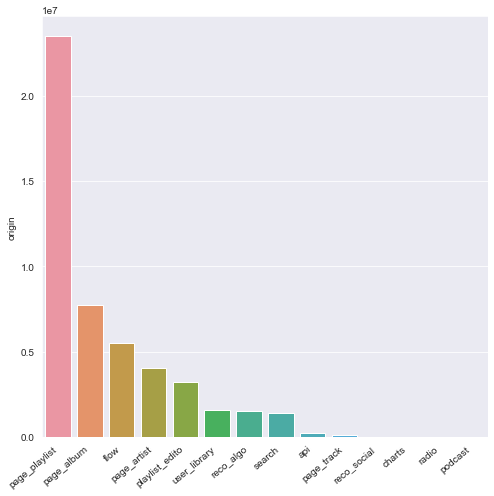

In [11]:
test = data["origin"].value_counts().to_frame()

f, ax = plt.subplots(figsize=(7, 7))

sns.barplot(x=test.index, y="origin", data=test)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

plt.savefig("../../data/origin_distrib.pdf")

In [12]:
# Apply ternary origin tag
data["origin"] = data["origin"].apply(lambda x: is_reco(x))

data

,user_id,sng_id,origin,art_id,bin_nb
0,49d2e98bcb58048af766d54872159ebb9849973f,675801,orga,611,4
1,948e06ab49e2af86f67afd19778060049d770a13,6626876,orga,611,4
2,753b6c11ec65e8fb293e9f080a2494eb10f82f81,4288159,orga,611,4
3,948e06ab49e2af86f67afd19778060049d770a13,368596071,orga,611,4
4,d534403280a827590c5c291ceaca620857eea70b,4288159,orga,611,4
...,...,...,...,...,...
48903876,46e49db5a93b068640c0d35c753273fd2dd203d7,814556382,orga,1589988,4
48903877,46e49db5a93b068640c0d35c753273fd2dd203d7,814556382,orga,1589988,4
48903878,46e49db5a93b068640c0d35c753273fd2dd203d7,814556382,orga,1589988,4
48903879,46e49db5a93b068640c0d35c753273fd2dd203d7,814556382,orga,1589988,4


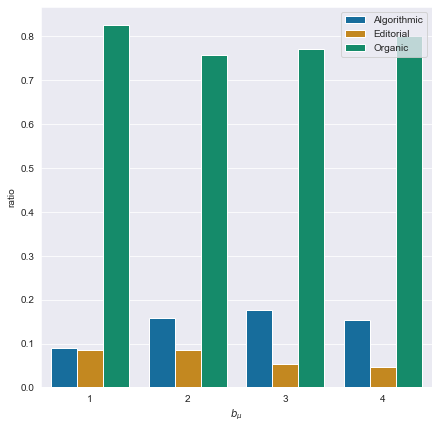

In [13]:
# Computing % of recommended to organic plays in each mainstream bin
bin_plays = data.groupby(['bin_nb']).size().to_frame().reset_index()
bin_plays_tripled = pd.DataFrame(np.repeat(bin_plays.values, 3, axis=0))
bin_plays_tripled.columns = bin_plays.columns
bin_plays_rec = data.groupby(["bin_nb", "origin"]).size().to_frame().reset_index()
bin_plays_rec[0] = bin_plays_rec[0].divide(bin_plays_tripled[0])

f, ax = plt.subplots(figsize=(7, 7))
ax = sns.barplot(x="bin_nb", y=0, hue="origin", data=bin_plays_rec)
ax.set(xlabel=r"$b_\mu$", ylabel="ratio")
leg = plt.legend()
leg.get_texts()[0].set_text('Algorithmic')
leg.get_texts()[1].set_text('Editorial')
leg.get_texts()[2].set_text('Organic')

plt.savefig("../../results/reco_ratio_per_binmn.pdf")

In [14]:
# Grouping users and their artist bin consumption
main_dist = data.groupby(["user_id", "recommended", "bin_nb"] if SEPARATE_RECO
                                else ["user_id", "bin_nb"]).size()
main_dist

user_id                                   bin_nb
000917cdc11c2f5bdf73080e977c2164dd3317e7  1         1117
                                          2          711
                                          3          288
                                          4          126
000f74e758dc95d4f10bcc30e94c294dab14fe6f  1         1750
                                                    ... 
ffee7b654a5a3b9a09f106aaf4a40e1a948f6509  4         2345
fff7883b935e4eeac717db3ce601a6012584c184  1          614
                                          2         1998
                                          3         1967
                                          4         1667
Length: 33426, dtype: int64

## Ternary plot for user bins

In [15]:
origin_ratios = data.groupby(["user_id", "origin"]).size()
user_plays = data.groupby(["user_id"]).size()

origin_ratios = origin_ratios.divide(user_plays, level=0)
origin_ratios

user_id                                   origin
000917cdc11c2f5bdf73080e977c2164dd3317e7  algo      0.030330
                                          edit      0.261820
                                          orga      0.707850
000f74e758dc95d4f10bcc30e94c294dab14fe6f  algo      0.041544
                                          edit      0.133208
                                                      ...   
ffee7b654a5a3b9a09f106aaf4a40e1a948f6509  edit      0.009053
                                          orga      0.903552
fff7883b935e4eeac717db3ce601a6012584c184  algo      0.458694
                                          edit      0.020013
                                          orga      0.521294
Length: 23396, dtype: float64

In [16]:
missing = origin_ratios.groupby("user_id").size() < 3
missing = missing[missing == True].index
tags = ["algo", "edit", "orga"]

for user in missing:
    for t in [tag for tag in tags if tag not in origin_ratios[user].index.values]:
        origin_ratios.loc[user, t] = 0.0


In [17]:
points = list(origin_ratios.to_frame().sort_values(["user_id", "origin"]).groupby("user_id")[0].apply(list).reset_index()[0].values)

In [18]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

points_data = StandardScaler().fit_transform(points)
points_data

array([[-0.53756529,  1.7117987 , -0.35250539],
       [-0.4824419 ,  0.54714301,  0.16689707],
       [ 0.11637837, -0.32087111,  0.0520233 ],
       ...,
       [ 0.27207182,  1.02963802, -0.74792403],
       [-0.25704892, -0.57715892,  0.51333534],
       [ 1.56813808, -0.47791052, -1.17788642]])

In [19]:
n_clusters_ = 4
labels = KMeans(n_clusters=n_clusters_, random_state=169).fit_predict(points_data)
pd.Series(labels).value_counts()

1    4533
0    2133
3    1182
2     537
dtype: int64

In [328]:
db = DBSCAN(eps=0.3, min_samples=10).fit(points_data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(points_data, labels))

pd.Series(labels).value_counts()

Estimated number of clusters: 1
Estimated number of noise points: 111
Silhouette Coefficient: 0.622


 0    8274
-1     111
dtype: int64

In [20]:
# How could this even be done in a Pythonic, faster way? I couldn't take the time to do it cuz it's only for a few thousand n
points_list = [[] for i in range(n_clusters_)]
points_noise = []
for i in range(len(points)):
    if labels[i] == -1:
        points_noise.append(points[i])
    else:
        points_list[labels[i]].append(points[i])


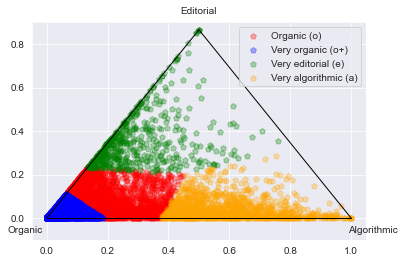

In [21]:
figure, tax = ternary.figure(scale=1)
# tax.set_title("Scatter Plot", fontsize=10)
tax.boundary(linewidth=1.0)
# tax.gridlines(multiple=5, color="blue")

colors = ["red", "blue", "green", "orange", "purple", "magenta", "yellow", "cyan", "azure", "lime", "silver", "teal", "hotpink"]

cluster_names = ["Organic (o)", "Very organic (o+)", "Very editorial (e)", "Very algorithmic (a)"]
for i in range(len(points_list)):
    tax.scatter(points_list[i], marker='p', color=colors[i], label=f"{cluster_names[i]}", alpha=0.3)

# tax.scatter(points_noise, marker='p', color='black', label="noise", alpha=0.1)

tax.right_corner_label("Algorithmic", fontsize=10)
tax.top_corner_label("Editorial", fontsize=10)
tax.left_corner_label("Organic", fontsize=10)
tax.legend()
# tax.ticks(axis='lbr', linewidth=1, multiple=.1)

tax.show()
tax.savefig(f"../../results/tern_plot_kmeans_{n_clusters_}_clusters.pdf")

In [22]:
# TODO IMPORTANT -- REDRAW FIGURES WITH THOSE INVERTED 1 AND 0 LABELS
where_0 = np.where(labels == 0)
where_1 = np.where(labels == 1)

labels[where_0] = 1
labels[where_1] = 0

In [23]:
points_df = pd.DataFrame(points)
points_df["label"] = labels
points_df.rename(columns={0: "algo", 1: "edit", 2: "orga"}).to_csv("../../data/kmeans_points.csv", index=False)

In [23]:
points_df

,0,1,2,label
0,0.030330,0.261820,0.707850,1
1,0.041544,0.133208,0.825248,1
2,0.163362,0.037354,0.799284,1
3,0.000000,0.002861,0.997139,0
4,0.019909,0.037298,0.942792,0
...,...,...,...,...
8380,0.508312,0.128001,0.363687,3
8381,0.484704,0.149779,0.365517,3
8382,0.195035,0.186490,0.618476,1
8383,0.087396,0.009053,0.903552,0


In [24]:
user_bins = pd.DataFrame(data={"user_id": data.groupby(["user_id"]).size().index.values, "bin_u": labels})
user_bins["bin_u"] += 1
user_bins

,user_id,bin_u
0,000917cdc11c2f5bdf73080e977c2164dd3317e7,2
1,000f74e758dc95d4f10bcc30e94c294dab14fe6f,2
2,00111b3c8e65d6f1238747f1b3ac2a9acf931400,2
3,0012d9783ec39191c1712e16a53726619798390e,1
4,0017c2c4addf980a77f33a110adbc874a4bacff6,1
...,...,...
8380,ffda9ab0659751c81b9f2ceb3d080b41dd9f063a,4
8381,ffe04a9a7a7cfa81d78f30f2c902b700ed20d959,4
8382,ffeacc108cd39b36cbb8a667631e1a9f3d408ddd,2
8383,ffee7b654a5a3b9a09f106aaf4a40e1a948f6509,1


In [25]:
u_bin_dict = {1: "o+", 2:"o", 3:"e", 4:"a"}
user_bins["bin_u_s"] = user_bins["bin_u"].map(lambda x: u_bin_dict[x])
user_bins

,user_id,bin_u,bin_u_s
0,000917cdc11c2f5bdf73080e977c2164dd3317e7,2,o
1,000f74e758dc95d4f10bcc30e94c294dab14fe6f,2,o
2,00111b3c8e65d6f1238747f1b3ac2a9acf931400,2,o
3,0012d9783ec39191c1712e16a53726619798390e,1,o+
4,0017c2c4addf980a77f33a110adbc874a4bacff6,1,o+
...,...,...,...
8380,ffda9ab0659751c81b9f2ceb3d080b41dd9f063a,4,a
8381,ffe04a9a7a7cfa81d78f30f2c902b700ed20d959,4,a
8382,ffeacc108cd39b36cbb8a667631e1a9f3d408ddd,2,o
8383,ffee7b654a5a3b9a09f106aaf4a40e1a948f6509,1,o+


In [26]:
data = data.merge(user_bins, on="user_id")
data

,user_id,sng_id,origin,art_id,bin_nb,bin_u,bin_u_s
0,49d2e98bcb58048af766d54872159ebb9849973f,675801,orga,611,4,4,a
1,49d2e98bcb58048af766d54872159ebb9849973f,675801,orga,611,4,4,a
2,49d2e98bcb58048af766d54872159ebb9849973f,675801,orga,611,4,4,a
3,49d2e98bcb58048af766d54872159ebb9849973f,675801,orga,611,4,4,a
4,49d2e98bcb58048af766d54872159ebb9849973f,675801,algo,611,4,4,a
...,...,...,...,...,...,...,...
48903876,07cde156200ef765a0754d62753d2addd812bb53,515170242,orga,445119,4,1,o+
48903877,07cde156200ef765a0754d62753d2addd812bb53,515170242,orga,445119,4,1,o+
48903878,07cde156200ef765a0754d62753d2addd812bb53,139816171,orga,7792810,4,1,o+
48903879,07cde156200ef765a0754d62753d2addd812bb53,139816171,orga,7792810,4,1,o+


In [28]:
data.to_csv("../../data/spring2020/all_binned.csv", index=False)

In [29]:
# Saving user bins and P
user_bins.merge(data.groupby("user_id").size().to_frame(), on="user_id").rename(columns={0: "plays"}).to_csv("../../data/user_bins.csv", index=False)

# Users pre-binning based on recommendation usage

In [19]:
# Determining rate of recommended to organic for users
data["recommended"] = data["origin"].map(lambda x: True if x == "algo" or x == "edit" else False)
users_reco = data.groupby(["user_id", "recommended"]).size().reset_index()
users_reco.columns = ["user_id", "recommended", "amnt"]

# Checking if all users have both types before division
users_reco_types = users_reco.groupby(["user_id"]).size()
users_reco_types = list(users_reco_types[users_reco_types == 1].index)

# Adding True column for False-only users and vice-versa
to_add = users_reco[users_reco["user_id"].isin(users_reco_types)]
to_add.loc[:, "recommended"] = ~to_add["recommended"]
# Not using 0 to avoid divisions -- in practice, this won't affect the bins
to_add.loc[:, "amnt"] = 1
users_reco = users_reco.append(to_add).sort_values(by=["user_id"])

users_reco.loc[:, "rate"] = 0
rec_amnts = users_reco[users_reco["recommended"] == True]["amnt"].values
org_amnts = users_reco[users_reco["recommended"]== False]["amnt"].values

# Changing users_reco into the final DataFrame
users_reco = users_reco[users_reco.recommended == True].drop(["recommended", "amnt"], axis=1)
users_reco.loc[:, "rate"] = rec_amnts / (rec_amnts + org_amnts)

# Adding nb of plays to users_reco in order to form bins with equal amounts of plays
users_reco = main_dist.groupby("user_id").sum().to_frame().merge(users_reco, left_on="user_id", right_on="user_id").sort_values("rate", ascending=True)
users_reco["cumplays"] = users_reco[0].cumsum()
users_reco

c:\users\quentin.villermet\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,user_id,0,rate,cumplays
3825,74342b38bb27c6591b7f81f9d9e6fd72d577fe8b,10851,0.000092,10851
1970,3c116b7fca5966758614f1377159c4e4609aeaa5,9530,0.000105,20381
357,0b2e19d9fc500f8f764b32e66b673eebdd0471b5,8754,0.000114,29135
475,0e601d3fcf56735adfa39a1fc1cf23d2554efa69,8688,0.000115,37823
6304,c18e4d560fcee0f61ab4e02480cfa63c4479b883,8607,0.000116,46430
...,...,...,...,...
890,1b76e21b3a382abc40b045c3f27f5e842ab4d6f7,186,0.994652,48897331
1462,2c8a896dd44cf0a652f4ebb901afb64c3d4c1fcb,3003,0.994672,48900334
6756,ceec86a4896005f3472cfcefb400b50bde658b97,271,0.996324,48900605
2643,5098ac874605884b105136a34999867dbcfcac80,347,0.997126,48900952


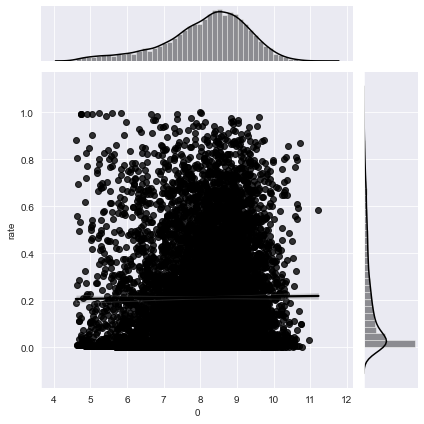

In [25]:
sns.jointplot(x=np.log(users_reco[0]), y="rate", data=users_reco, kind="reg", color="k");

Number of users per bin: 
u_bin
(-38042.03, 12234108.5]     2111
(12234108.5, 24457366.0]    2033
(24457366.0, 36680623.5]    2142
(36680623.5, 48903881.0]    2099
dtype: int64
Users binned into 4 categories.


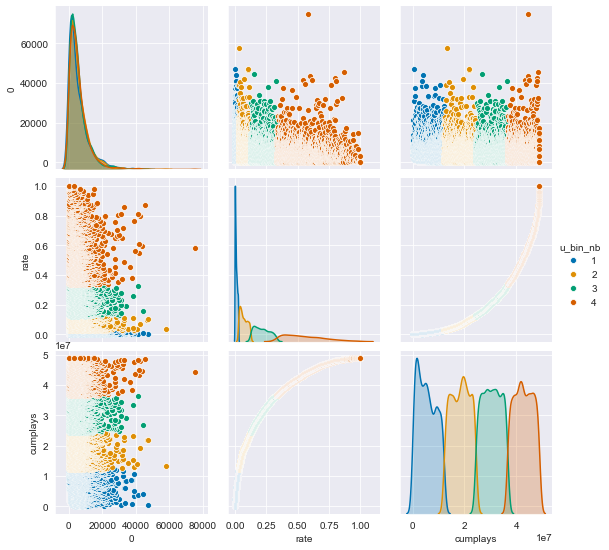

0.028861694758716232
0.12602161877142104
0.33580810965162766
0.9996587030716724


In [15]:
USER_BINS = 4
# Cutting into bins
users_reco["u_bin"] = pd.cut(users_reco["cumplays"], USER_BINS, duplicates="drop")
print(f"Number of users per bin: \n{users_reco.groupby('u_bin').size()}")

# Assigning corresponding numbers to bins
users_reco["u_bin_nb"] = (users_reco["u_bin"].cat.codes + 1).values
print(f"Users binned into {users_reco['u_bin_nb'].max()} categories.")
sns.pairplot(users_reco, hue="u_bin_nb")
plt.show()
# print(users_reco["rate"].median())
print(users_reco[users_reco["u_bin_nb"] == 1]["rate"].max())
print(users_reco[users_reco["u_bin_nb"] == 2]["rate"].max())
print(users_reco[users_reco["u_bin_nb"] == 3]["rate"].max())
print(users_reco[users_reco["u_bin_nb"] == 4]["rate"].max())

# users_reco[["user_id", "rate", 0, "u_bin_nb"]].to_csv("../../data/user_bins.csv", index=False)
users_reco.drop(["u_bin", "rate"], axis=1, inplace=True)

# sns.distplot(users_reco[users_reco["bin_nb"] == 4]["rate"], kde=False)

In [16]:
artist_data.merge(users_reco[["user_id", "u_bin_nb"]], on="user_id").rename(columns={"bin_nb": "bin_mn", "u_bin_nb": "bin_u"}).to_csv("../../data/data_binned_clean.csv", index=False)

In [30]:
users_reco.groupby("u_bin_nb").size().to_frame().reset_index()

,u_bin_nb,0
0,1,2111
1,2,2033
2,3,2142
3,4,2099


In [31]:
# Amount of plays per user bin
main_dist.groupby("user_id").sum().to_frame().merge(users_reco, left_on="user_id", right_on="user_id").groupby("u_bin_nb").sum()

,0_x,0_y,cumplays
u_bin_nb,,,
1,12230547,12230547,11884583151
2,12223591,12223591,37593153793
3,12222491,12222491,65516246345
4,12227252,12227252,89909993124


In [33]:
# Testing correctness of user frame ratios
# user_frame = get_user_frame(main_dist, bin_distrib)
# user_frame.groupby("user_id")["ratio"].sum().values.mean()

user_frame = get_user_frame(bin_distrib).merge(users_reco, left_on="user_id", right_on="user_id").drop(["user_id"], axis=1)

# Geometric mean
# user_bin_ratios = user_frame.groupby(["u_bin_nb", "bin_nb"])["ratio"].apply(stats.gmean).to_frame().reset_index()
user_bin_ratios = user_frame.groupby(["u_bin_nb", "bin_nb"])["ratio"].apply(np.mean).to_frame().reset_index()

print(user_bin_ratios.groupby("u_bin_nb")["ratio"].sum().values.mean())

# Log ratio
user_bin_ratios["ratio"] = user_bin_ratios["ratio"].map(np.log)

4.014131778008377


# Computing bin_distrib -- Vectorized version

In [35]:
user_frame = get_user_frame(bin_distrib)

In [36]:
# Saving frame
user_frame.to_csv("mainstream_ratios.csv", index=False)

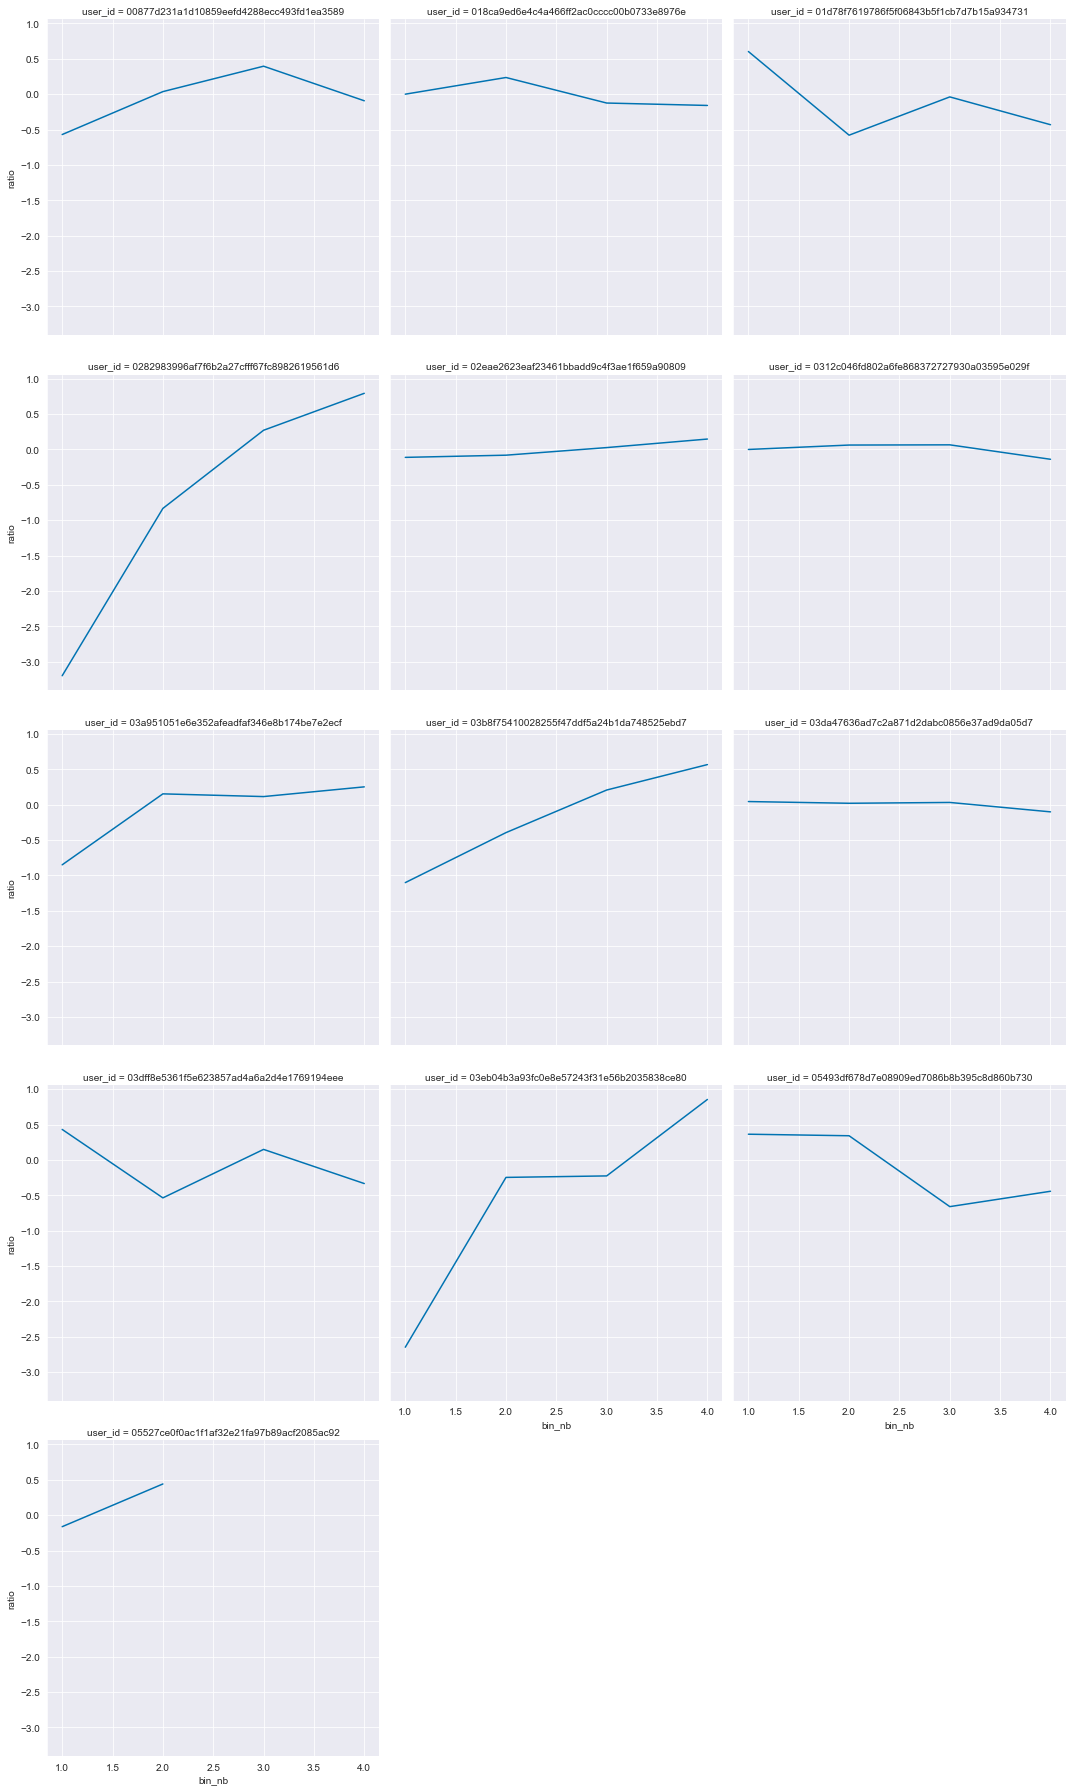

In [23]:
# Log for ratio
user_frame["ratio"] = user_frame["ratio"].map(np.log)

# Plotting the first users
sns.relplot(x="bin_nb", y="ratio", kind="line", col="user_id", col_wrap=3, dashes=False, markers=True,
            estimator=None, data=user_frame[:50], legend=False)

In [110]:
bin_bin_plays_tot.groupby("bin_u").sum()
(bin_bin_plays_tot[0] - plays_distrib["expected"])

,bin_nb,0,delta
bin_u,,,
1,10,26830424,-0.009735
2,10,12298774,-0.006330
3,10,2555243,-0.075769
4,10,7219440,-0.081682


# Are recommendations favorizing mainstream content?

In [27]:
# Trying to go back from zero -- instead of ratios, working with deltas considering each bin+bin_u has about the same amount of plays
bin_bin_plays = data.drop(["sng_id"], axis=1).groupby(["bin_nb", "bin_u", "origin"]).size().to_frame().reset_index()

u_bin_distrib = data.groupby("bin_u").size()
plays_distrib = pd.Series(dtype="float64")
for i in range(1, BIN_AMNT+1):
    plays_distrib = plays_distrib.append(u_bin_distrib * bin_distrib[i])

bin_bin_plays
plays_distrib = plays_distrib.to_frame().reset_index()
plays_distrib.columns = ["binu", "expected"]
plays_distrib["binmn"] = np.repeat(np.arange(1, 5, 1), 4)

# Combine rec and org -- for total version
bin_bin_plays_tot = bin_bin_plays
bin_bin_plays_tot = bin_bin_plays_tot.groupby(["bin_nb", "bin_u"]).sum().reset_index()
bin_bin_plays_tot["delta"] = np.log(bin_bin_plays_tot[0]) - np.log(plays_distrib["expected"]) # Log or not ? That is the question
bin_bin_plays_tot

,bin_nb,bin_u,0,delta
0,1,1,7523976,0.109872
1,1,2,2785598,-0.103723
2,1,3,742722,0.145733
3,1,4,1234721,-0.384619
4,2,1,6355652,-0.049539
5,2,2,3124389,0.020392
6,2,3,770332,0.191572
7,2,4,1922430,0.067465
8,3,1,6373397,-0.050714
9,3,2,3177873,0.033403


In [34]:
bin_bin_plays_tot["delta"] = bin_bin_plays_tot["delta"].map(np.abs)
bin_bin_plays_tot.groupby("bin_u").sum()["delta"] / plays_distrib.groupby("binu").sum()["expected"]

bin_u
1    8.552935e-09
2    1.635261e-08
3    2.936621e-07
4    9.523675e-08
dtype: float64

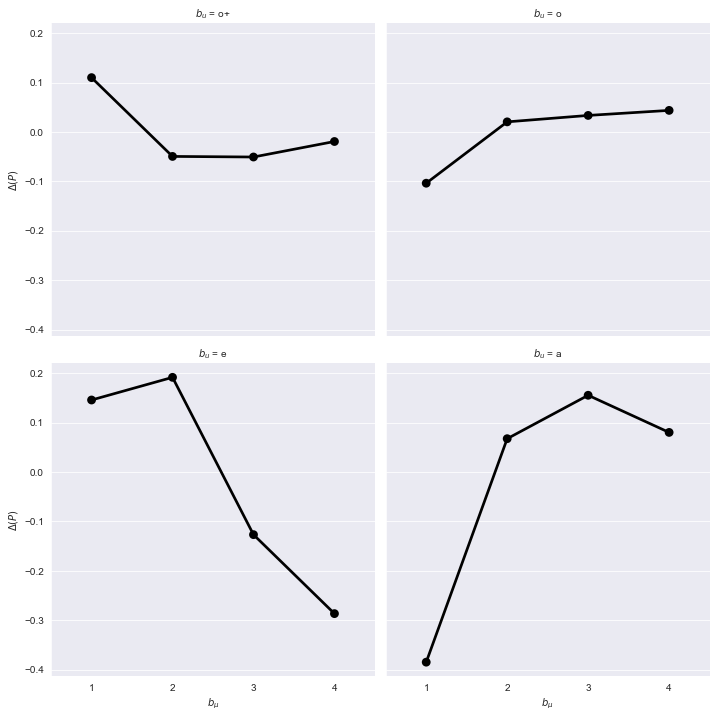

In [28]:
# New binning
bin_bin_plays_tot["bin_u_s"] = bin_bin_plays_tot["bin_u"].map(lambda x: u_bin_dict[x])

h = sns.catplot(x="bin_nb", y="delta", col="$b_u$", col_wrap=2, kind="point", color="black",
                data=bin_bin_plays_tot.rename(columns={"u_bin_nb": "bin_u", "bin_u_s": r"$b_u$"}))
h.set_axis_labels(r'$b_\mu$', r'$\Delta(P)$')
sns.set(font_scale=1)
plt.savefig("../../results/bin_bin_logdeltas.pdf")

In [29]:
# Separated version
plays_distrib_sep = plays_distrib.apply(lambda x: np.repeat(x, 3)).reset_index().drop("index", axis=1)
plays_distrib_sep["rec"] = ["algo", "edit", "orga"] * 16

binu_plays_rec = data.groupby(["bin_u", "origin"]).size().to_frame().reset_index()
binu_plays_rec[0] = binu_plays_rec[0].divide(bin_plays_tripled[0])

# rec_ratio = artist_data["recommended"].value_counts()[True] / artist_data["recommended"].value_counts().sum()
# org_ratio = 1 - rec_ratio

plays_distrib_sep["expected"] = plays_distrib_sep["expected"] * pd.concat([binu_plays_rec]*4, ignore_index=True)[0]
plays_distrib_sep

plays_distrib_sep = plays_distrib_sep.reset_index().drop("index", axis=1)
bin_bin_plays["expected"] = plays_distrib_sep["expected"]
bin_bin_plays["delta"] = np.log(bin_bin_plays[0]) - np.log(plays_distrib_sep["expected"])

bin_bin_plays

,bin_nb,bin_u,origin,0,expected,delta
0,1,1,algo,107401,3.603369e+05,-1.210470
1,1,1,edit,213221,3.691414e+05,-0.548851
2,1,1,orga,7203354,1.399066e+07,-0.663843
3,1,2,algo,336649,5.159229e+05,-0.426917
4,1,2,edit,386837,3.191602e+05,0.192310
5,1,2,orga,2062112,2.286940e+06,-0.103484
6,1,3,algo,50326,1.213978e+04,1.422035
7,1,3,edit,339150,5.211872e+04,1.872918
8,1,3,orga,353246,6.997351e+04,1.619048
9,1,4,algo,609561,6.111507e+05,-0.002605


In [80]:
bin_bin_plays.groupby(["bin_u", "origin"]).sum()

bin_nb         0      expected     delta
bin_u origin                                          
1     algo        10    656787  1.434186e+06 -3.228146
      edit        10    672835  1.469230e+06 -3.226490
      orga        10  25500802  5.568458e+07 -3.135146
2     algo        10   2032406  2.053438e+06 -0.137188
      edit        10   1257287  1.270298e+06 -0.143317
      orga        10   9009081  9.102312e+06 -0.048857
3     algo        10    231093  4.831784e+04  6.044950
      edit        10    992133  2.074391e+05  5.979296
      orga        10   1332017  2.785034e+05  6.251204
4     algo        10   4118290  2.432457e+06  1.957814
      edit        10    354191  2.092020e+05  1.992487
      orga        10   2746959  1.622484e+06  2.059210

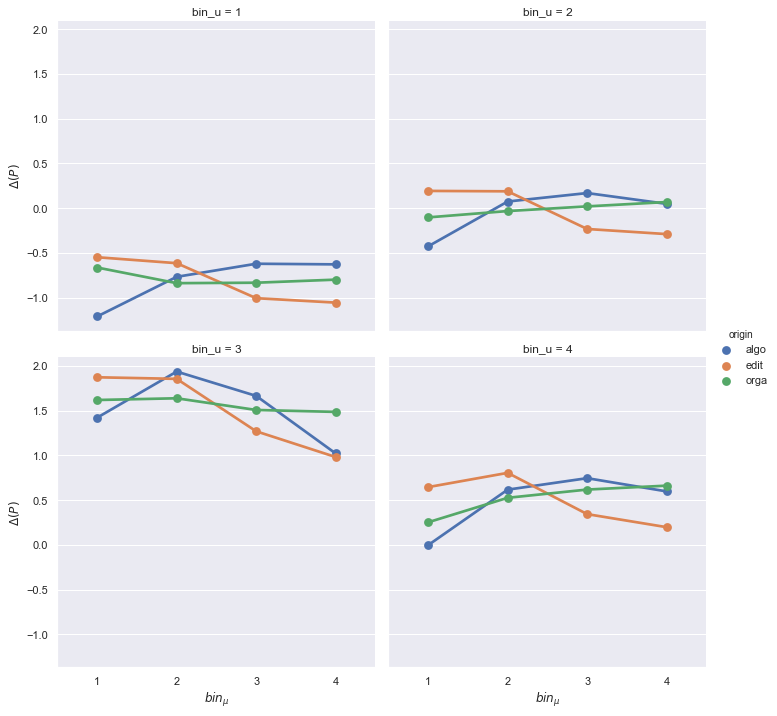

In [104]:
sns.set(font_scale=1)

h = sns.catplot(x="bin_nb", y="delta", col="bin_u", col_wrap=2, hue="origin", kind="point", data=bin_bin_plays.rename(columns={"u_bin_nb": "bin_u"}), log=True)
h.set_axis_labels(r'$bin_\mu$', r'$\Delta(P)$')
# h.set(yscale="log")
# plt.yscale("symlog")

plt.savefig("../../results/bin_bin_logdeltas_sep.pdf")

In [30]:
reco_mainstream = data.drop("sng_id", axis=1)

# For each user bin (recommendation based grouping)
reco_mainstream = reco_mainstream.groupby(["bin_nb", "bin_u", "origin"]).size()
reco_mainstream = reco_mainstream.to_frame().reset_index()
reco_mainstream.columns = ["bin_nb", "bin_u", "origin", "amount"]

# Testing stuff right there -- loop version because I have no idea how to vectorize this for now
test = reco_mainstream.groupby(["bin_u", "origin"]).mean().reset_index()

reco_mainstream["amount"] = reco_mainstream["amount"].astype(float)

for i, row in reco_mainstream.iterrows():
    reco_mainstream.at[i, "amount"] /= test[(test["bin_u"] == reco_mainstream.at[i, "bin_u"]) & (test["origin"] == reco_mainstream.at[i, "origin"])]["amount"]

# Mean mainstream bin for recommended vs. organic
test = reco_mainstream.groupby(["bin_nb", "origin"])["amount"].sum().to_frame().reset_index()
print(test)
test_org = test[test["origin"] == "orga"]
test_edi = test[test["origin"] == "edit"]
test_alg = test[test["origin"] == "algo"]
print(f'Mean mainstream bin for organic plays: {(test_org["amount"] * test_org["bin_nb"]).sum() / test_org["amount"].sum()}')
print(f'Mean mainstream bin for algorithmic plays: {(test_alg["amount"] * test_alg["bin_nb"]).sum() / test_alg["amount"].sum()}')
print(f'Mean mainstream bin for editorial plays: {(test_edi["amount"] * test_edi["bin_nb"]).sum() / test_edi["amount"].sum()}')

# Log ratio
reco_mainstream["amount"] = reco_mainstream["amount"].map(np.log)

reco_mainstream

    bin_nb origin    amount
0        1   algo  2.779810
1        1   edit  4.997974
2        1   orga  3.870588
3        2   algo  4.626180
4        2   edit  5.035202
5        2   orga  3.980161
6        3   algo  4.716264
7        3   edit  3.174070
8        3   orga  4.017740
9        4   algo  3.877746
10       4   edit  2.792754
11       4   orga  4.131511
Mean mainstream bin for organic plays: 2.525635851172781
Mean mainstream bin for algorithmic plays: 2.6057466237538436
Mean mainstream bin for editorial plays: 2.235100208752071


,bin_nb,bin_u,origin,amount
0,1,1,algo,-0.424496
1,1,1,edit,0.237123
2,1,1,orga,0.122131
3,1,2,algo,-0.411640
4,1,2,edit,0.207586
5,1,2,orga,-0.088208
6,1,3,algo,-0.138004
7,1,3,edit,0.312880
8,1,3,orga,0.059009
9,1,4,algo,-0.524160


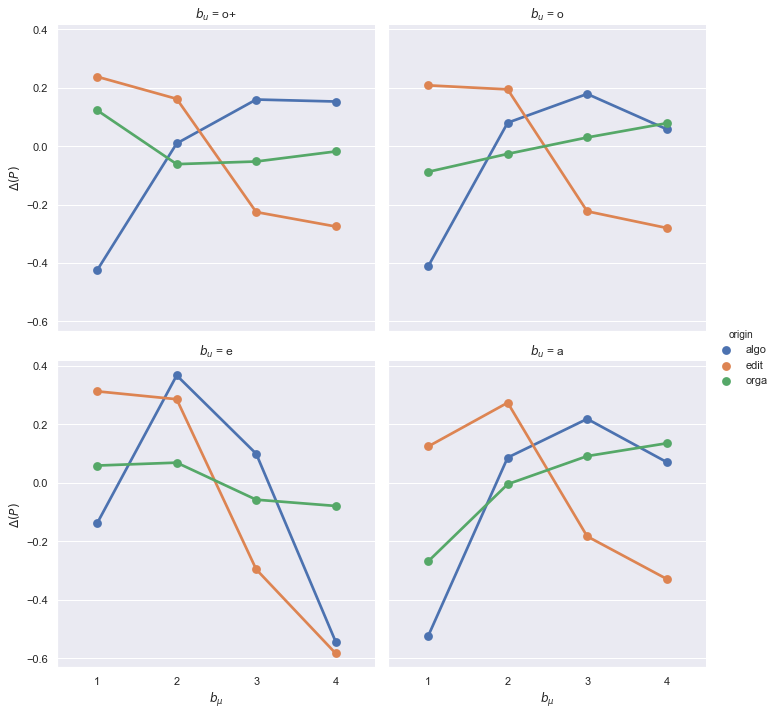

In [32]:
# New binning
reco_mainstream["bin_u_s"] = reco_mainstream["bin_u"].map(lambda x: u_bin_dict[x])

h = sns.catplot(x="bin_nb", y="amount", col="$b_u$", col_wrap=2, hue="origin", kind="point", data=reco_mainstream.rename(columns={"bin_u_s": r"$b_u$"}))
h.set_axis_labels(r'$b_\mu$', r'$\Delta(P)$')
plt.savefig("../../results/binu_binm_plays_distrib.pdf")

## Are organic non-mainstream listenings the result of previous recommendations?

In [13]:
# Removing non-valid timestamps (aberrant values and timestamps outside the bulk of the dataset)
truncated_data = artist_data.drop(artist_data[artist_data["ts"] < 1473000000].index)

# Removing the first month of data to try and ensure most of the first listens are actually first listens
min_ts = truncated_data["ts"].min() + 2592000
truncated_data = truncated_data[truncated_data["ts"] > min_ts]


# Finding songs for each user that were listened to only once 
single_listens = truncated_data.groupby(["user_id", "sng_id"]).size()
single_listens = single_listens[single_listens < 2].to_frame().index

# Removing singletons from dataset
# data_no_singletons = (artist_data[~pd.Series(list(zip(artist_data['user_id'], artist_data['sng_id']))).isin(single_listens)])[["user_id", "ts", "sng_id", "recommended"]]
# data_no_singletons = data_no_singletons.reset_index().drop("index", axis=1)
single_listens = truncated_data.groupby(["user_id", "sng_id"]).size()
single_listens = single_listens[single_listens < 2].to_frame().reset_index()[["user_id", "sng_id"]]
single_listens["drop"] = True
data_no_singletons = truncated_data.merge(single_listens, how="left", left_on=["user_id", "sng_id"], right_on=["user_id", "sng_id"])
data_no_singletons = data_no_singletons[data_no_singletons["drop"] != True]
data_no_singletons = data_no_singletons[["user_id", "ts", "sng_id", "recommended"]]

data_no_singletons = data_no_singletons.sort_values(by=["user_id", "ts"]).reset_index().drop("index", axis=1)

data_no_singletons

,user_id,ts,sng_id,recommended
0,00877d231a1d10859eefd4288ecc493fd1ea3589,1475598228,13792835,True
1,00877d231a1d10859eefd4288ecc493fd1ea3589,1475598429,3134033,True
2,00877d231a1d10859eefd4288ecc493fd1ea3589,1475598792,109734566,True
3,00877d231a1d10859eefd4288ecc493fd1ea3589,1475601406,106152016,True
4,00877d231a1d10859eefd4288ecc493fd1ea3589,1475601705,107394234,True
...,...,...,...,...
525831,ff82befb6c2bcf11c638706bc27cf787128426de,1479497155,108692368,False
525832,ff82befb6c2bcf11c638706bc27cf787128426de,1479538385,108692368,False
525833,ff82befb6c2bcf11c638706bc27cf787128426de,1479538643,108692368,False
525834,ff82befb6c2bcf11c638706bc27cf787128426de,1479711552,108692368,False


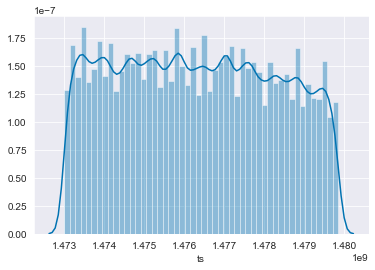

In [24]:
sns.distplot(data_no_singletons["ts"])

In [43]:
# Loop form -- maybe vectorizable at some point?
current_user = ""
user_dict = {}

adopted_table = pd.DataFrame(columns=["user_id", "sng_id", "adopted"])
for i, row in data_no_singletons.iterrows():
    if current_user != row["user_id"]:
        # New user -- soft reset
        current_user = row["user_id"]
        # Adding non-adopted songs (i.e. entries in the dict with a value of zero)
        if not all(user_dict.values()):
            for sng in {x:y for x,y in user_dict.items() if y==0}:
                adopted_table = pd.concat([adopted_table, pd.DataFrame([[current_user, sng, False]], columns=["user_id", "sng_id", "adopted"])],
                                       ignore_index=True)
        user_dict = {}
        
    # Adding entry to dict for first listens
    if row["sng_id"] not in user_dict and row["recommended"]:
        user_dict[row["sng_id"]] = 0

    # Adding to adopted table if adopted
    if row["sng_id"] in user_dict and not row["recommended"]:
        user_dict[row["sng_id"]] += 1
        # Listen type different from the first time
        if (adopted_table[(adopted_table["user_id"] == current_user) & (adopted_table["sng_id"] == row["sng_id"])]).empty:
#             if [current_user, row["sng_id"]] not in adopted_table[adopted_table.columns[:2]].values:
            # Value not yet in the table
            adopted_table = pd.concat([adopted_table, pd.DataFrame([[current_user, row["sng_id"], True]], columns=["user_id", "sng_id", "adopted"])],
                                       ignore_index=True)
                
    if i % 50000 == 0:
        print(i)

adopted_table

0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000


,user_id,sng_id,adopted
0,00877d231a1d10859eefd4288ecc493fd1ea3589,857985,True
1,00877d231a1d10859eefd4288ecc493fd1ea3589,106152016,True
2,00877d231a1d10859eefd4288ecc493fd1ea3589,2232655,True
3,00877d231a1d10859eefd4288ecc493fd1ea3589,757085,True
4,00877d231a1d10859eefd4288ecc493fd1ea3589,7045661,True
...,...,...,...
34429,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,908995,False
34430,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,72299954,False
34431,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,70266756,False
34432,fea927761d221701b2bf1b6acc2de6d91d060071,71483067,False


In [44]:
adopted_table.to_csv("adopted_table.csv", index=False)

In [14]:
adopted_table = pd.read_csv("adopted_table.csv")

## Total version

In [62]:
song_bins = artist_data[["sng_id", "bin_nb"]].drop_duplicates().reset_index().drop(["index"], axis=1)

# Adding mainstream bins to adopted_table
adopted_table = adopted_table.merge(song_bins[["sng_id", "bin_nb"]], left_on="sng_id", right_on="sng_id")
adopted_table

,user_id,sng_id,adopted,bin_nb
0,00877d231a1d10859eefd4288ecc493fd1ea3589,3599714,True,2
1,05493df678d7e08909ed7086b8b395c8d860b730,3599714,False,2
2,06c9e7762c83ab9358c845274eee7be7cd4331b3,3599714,False,2
3,11a1e13499a8ea7303dba477122e8202de8a24bb,3599714,False,2
4,2ad14bc4eb38a15310b0b00b87494a67ed47100d,3599714,False,2
...,...,...,...,...
61217,fe016f7c946213bd53ca9b683b7314d24d2dbba9,76849955,False,4
61218,fe016f7c946213bd53ca9b683b7314d24d2dbba9,73706048,True,4
61219,fe016f7c946213bd53ca9b683b7314d24d2dbba9,62986059,True,4
61220,fe22a3978a595c3a63cb40558db7804956f8e1d7,109182794,False,4


In [63]:
adopted_count = adopted_table.groupby(["bin_nb", "adopted"]).size().to_frame().reset_index()
adopted_count.columns = ["bin_nb", "adopted", "count"]
adopted_count

,bin_nb,adopted,count
0,1,False,5457
1,1,True,3247
2,2,False,10084
3,2,True,4495
4,3,False,13831
5,3,True,5534
6,4,False,13196
7,4,True,5378


In [64]:
# Normalization
means = adopted_count.groupby(["bin_nb"]).sum().reset_index()

adopted_count["count"] = adopted_count["count"].astype(float)
for i, row in adopted_count.iterrows():
    adopted_count.at[i, "count"] /= means[means["bin_nb"] == row["bin_nb"]]["count"]
    
# No need to keep org_to_rec
adopted_count = adopted_count[adopted_count["adopted"] == True]
adopted_count

,bin_nb,adopted,count
1,1,True,0.373047
3,2,True,0.308320
5,3,True,0.285773
7,4,True,0.289545


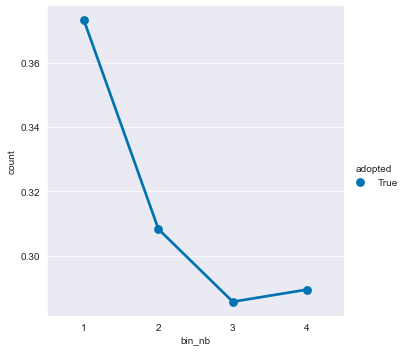

In [65]:
sns.catplot(x="bin_nb", y="count", hue="adopted", kind="point", data=adopted_count)

## User bin separation version

In [15]:
adopted_table = pd.read_csv("adopted_table.csv")

# Adding mainstream bins to adopted_table
song_bins = artist_data[["sng_id", "bin_nb"]].drop_duplicates().reset_index().drop(["index"], axis=1)
adopted_table = adopted_table.merge(song_bins[["sng_id", "bin_nb"]], left_on="sng_id", right_on="sng_id")

# Adding user_bins
adopted_table = adopted_table.merge(users_reco[["user_id", "u_bin_nb"]], left_on="user_id", right_on="user_id")

adopted_table

,user_id,sng_id,adopted,bin_nb,u_bin_nb
0,00877d231a1d10859eefd4288ecc493fd1ea3589,3599714,True,2,4
1,00877d231a1d10859eefd4288ecc493fd1ea3589,60842359,True,3,4
2,00877d231a1d10859eefd4288ecc493fd1ea3589,68437773,True,3,4
3,00877d231a1d10859eefd4288ecc493fd1ea3589,14233403,True,3,4
4,00877d231a1d10859eefd4288ecc493fd1ea3589,16571662,True,4,4
...,...,...,...,...,...
61003,b5c8e43539f4c498a2d58646b48bc91432d4f563,77698278,True,4,3
61004,b5c8e43539f4c498a2d58646b48bc91432d4f563,77698287,True,4,3
61005,b5c8e43539f4c498a2d58646b48bc91432d4f563,99976972,True,1,3
61006,e28bbf815d3ce6c4c601591c1a0155f573074134,2204604,True,4,1


In [67]:
adopted_count = adopted_table.groupby(["u_bin_nb", "bin_nb", "adopted"]).size().to_frame().reset_index()
adopted_count.columns = ["u_bin_nb", "bin_nb", "adopted", "count"]
adopted_count

,u_bin_nb,bin_nb,adopted,count
0,1,1,False,1426
1,1,1,True,67
2,1,2,False,2460
3,1,2,True,78
4,1,3,False,3379
5,1,3,True,78
6,1,4,False,3345
7,1,4,True,64
8,2,1,False,1380
9,2,1,True,392


In [68]:
# Normalization
means = adopted_count.groupby(["u_bin_nb", "bin_nb"]).sum().reset_index()

adopted_count["count"] = adopted_count["count"].astype(float)
for i, row in adopted_count.iterrows():
    adopted_count.at[i, "count"] /= means[(means["u_bin_nb"] == row["u_bin_nb"]) & (means["bin_nb"] == row["bin_nb"])]["count"]

# No need to keep org_to_rec
adopted_count = adopted_count[adopted_count["adopted"] == True]
adopted_count

,u_bin_nb,bin_nb,adopted,count
1,1,1,True,0.044876
3,1,2,True,0.030733
5,1,3,True,0.022563
7,1,4,True,0.018774
9,2,1,True,0.221219
11,2,2,True,0.120101
13,2,3,True,0.102651
15,2,4,True,0.114336
17,3,1,True,0.393559
19,3,2,True,0.337068


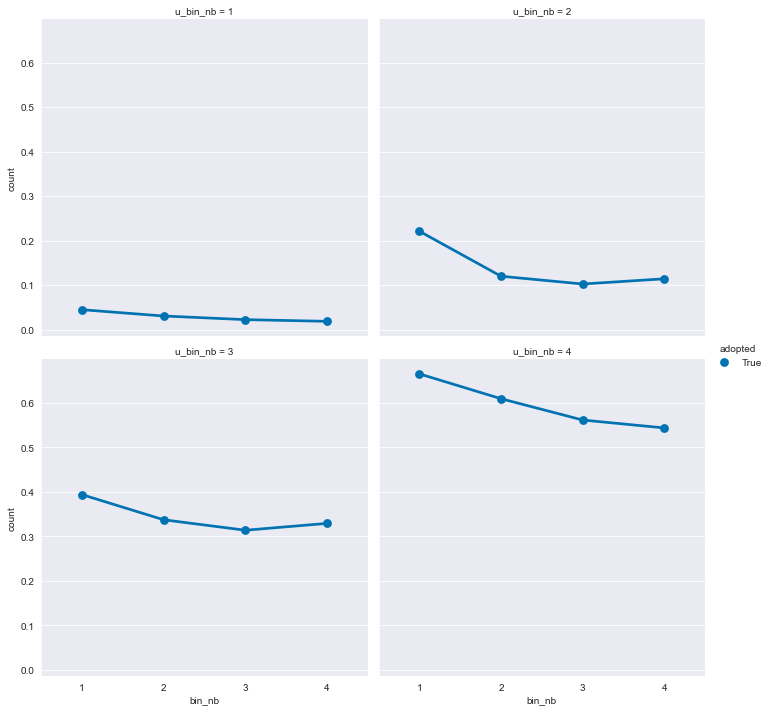

In [69]:
sns.catplot(x="bin_nb", y="count", hue="adopted", kind="point", col="u_bin_nb", col_wrap=2, data=adopted_count)

### Amount of re-listens after adoption

In [29]:
adopted_table

,user_id,sng_id,adopted,bin_nb,u_bin_nb
0,00877d231a1d10859eefd4288ecc493fd1ea3589,3599714,True,2,4
1,00877d231a1d10859eefd4288ecc493fd1ea3589,60842359,True,3,4
2,00877d231a1d10859eefd4288ecc493fd1ea3589,68437773,True,3,4
3,00877d231a1d10859eefd4288ecc493fd1ea3589,14233403,True,3,4
4,00877d231a1d10859eefd4288ecc493fd1ea3589,16571662,True,4,4
...,...,...,...,...,...
61003,b5c8e43539f4c498a2d58646b48bc91432d4f563,77698278,True,4,3
61004,b5c8e43539f4c498a2d58646b48bc91432d4f563,77698287,True,4,3
61005,b5c8e43539f4c498a2d58646b48bc91432d4f563,99976972,True,1,3
61006,e28bbf815d3ce6c4c601591c1a0155f573074134,2204604,True,4,1


In [17]:
# Getting amount of organic re-listens for adopted songs for each user
adopted_amount = data_no_singletons[data_no_singletons["recommended"] == False].groupby(["user_id", "sng_id"]).size().to_frame().reset_index()
adopted_amount.columns = ["user_id", "sng_id", "amount"]
adopted_amount = adopted_table.merge(adopted_amount, on=["user_id", "sng_id"], how="left").dropna()
adopted_amount = adopted_amount[adopted_amount["adopted"] == True]

adopted_amount

,user_id,sng_id,adopted,bin_nb,u_bin_nb,amount
0,00877d231a1d10859eefd4288ecc493fd1ea3589,3599714,True,2,4,1.0
3,00877d231a1d10859eefd4288ecc493fd1ea3589,14233403,True,3,4,1.0
9,00877d231a1d10859eefd4288ecc493fd1ea3589,70697364,True,1,4,2.0
10,00877d231a1d10859eefd4288ecc493fd1ea3589,65672691,True,2,4,1.0
12,00877d231a1d10859eefd4288ecc493fd1ea3589,7337274,True,4,4,2.0
...,...,...,...,...,...,...
61003,b5c8e43539f4c498a2d58646b48bc91432d4f563,77698278,True,4,3,6.0
61004,b5c8e43539f4c498a2d58646b48bc91432d4f563,77698287,True,4,3,3.0
61005,b5c8e43539f4c498a2d58646b48bc91432d4f563,99976972,True,1,3,1.0
61006,e28bbf815d3ce6c4c601591c1a0155f573074134,2204604,True,4,1,3.0


In [31]:
adopted_amount["amount"].sort_values()

0          1.0
36378      1.0
36371      1.0
36357      1.0
36341      1.0
         ...  
58599     94.0
58289     97.0
11017    105.0
7770     108.0
49877    119.0
Name: amount, Length: 13471, dtype: float64

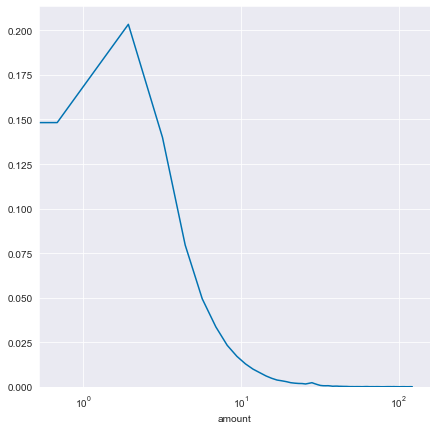

In [35]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", )
sns.distplot(adopted_amount["amount"], hist=False)

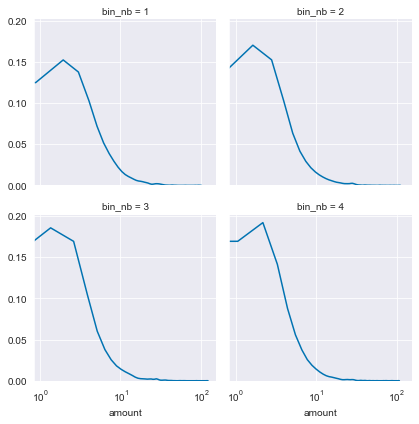

In [36]:
# Distribution per mainstream bin
# f, ax = plt.subplots(figsize=(7, 7))
g = sns.FacetGrid(adopted_amount, col="bin_nb", col_wrap=2)
g.set(xscale="log",)
g.map(sns.distplot, "amount", hist=False)

In [1]:
mean_relistens = adopted_amount.groupby(["bin_nb"])["amount"].mean().to_frame().reset_index()

ax = sns.catplot(x="bin_nb", y="amount", data=mean_relistens, kind="point")
ax.set(ylim=(0, 6))

NameError: name 'adopted_amount' is not defined

# SANDBOX

In [3]:
data = pd.read_csv("../../data/spring2020/all_binned.csv")
data

,user_id,sng_id,origin,art_id,bin_nb,bin_u
0,49d2e98bcb58048af766d54872159ebb9849973f,675801,orga,611,4,4
1,49d2e98bcb58048af766d54872159ebb9849973f,675801,orga,611,4,4
2,49d2e98bcb58048af766d54872159ebb9849973f,675801,orga,611,4,4
3,49d2e98bcb58048af766d54872159ebb9849973f,675801,orga,611,4,4
4,49d2e98bcb58048af766d54872159ebb9849973f,675801,algo,611,4,4
...,...,...,...,...,...,...
48903876,07cde156200ef765a0754d62753d2addd812bb53,515170242,orga,445119,4,1
48903877,07cde156200ef765a0754d62753d2addd812bb53,515170242,orga,445119,4,1
48903878,07cde156200ef765a0754d62753d2addd812bb53,139816171,orga,7792810,4,1
48903879,07cde156200ef765a0754d62753d2addd812bb53,139816171,orga,7792810,4,1


In [17]:
data.groupby("bin_u")["bin_nb"].mean()

bin_u
1    2.447411
2    2.554047
3    2.304885
4    2.662461
Name: bin_nb, dtype: float64

In [18]:
sp_data = pd.read_csv("../../data/sp_ratios_full.csv")

In [21]:
sp_data.groupby("bin_u")["ratio"].mean()

bin_u
1    0.270187
2    0.394645
3    0.413367
4    0.398968
Name: ratio, dtype: float64

In [4]:
bin_plays = data.groupby(['bin_nb']).size().to_frame().reset_index()
bin_plays_tripled = pd.DataFrame(np.repeat(bin_plays.values, 3, axis=0))
bin_plays_tripled.columns = bin_plays.columns
bin_plays_rec = data.groupby(["bin_nb", "origin"]).size().to_frame().reset_index()
bin_plays_rec[0] = bin_plays_rec[0].divide(bin_plays_tripled[0])

In [9]:
bin_plays_rec.groupby(["origin", "bin_nb"]).sum().unstack()

0                              
bin_nb         1         2         3         4
origin                                        
algo    0.089846  0.157878  0.175487  0.152842
edit    0.084599  0.084268  0.052681  0.046419
orga    0.825555  0.757854  0.771832  0.800740

In [24]:
data[data["bin_nb"] == 1].groupby(["art_id", "sng_id"]).size().to_frame().reset_index().sort_values(0, ascending=False)

,art_id,sng_id,0
12981,1042268,546875572,74113
12983,1042268,546875592,62934
10949,75491,561856742,61841
15680,5288900,658757872,58350
15363,5111084,583177742,57470
...,...,...,...
9950,3469,527589861,1
8217,1060,76310138,1
6979,1060,2178611,1
6978,1060,2178610,1
